In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
import time
from scipy import stats
from scipy import constants
from scipy.integrate import odeint
from scipy.optimize import curve_fit



from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cpu


In [2]:
data_h_lhs=pd.read_csv('h_LHS.csv',index_col=False)
# data_h_T_lhs=pd.read_csv('h_T_LHS.csv',index_col=False)
data_lambda_lhs=pd.read_csv('lambda_LHS.csv',index_col=False)
data_T_lhs=pd.read_csv('T_LHS.csv',index_col=False)

data_h_uniform_5000=pd.read_csv('h_uniform_5000.csv',index_col=False)
data_T_uniform_5000=pd.read_csv('T_uniform_5000.csv',index_col=False)


##testing lambda
data_lambda_uniform_5000=pd.read_csv('lambda_uniform_5000.csv',index_col=False)

In [22]:
### Reading values only
h_in=data_h_lhs.values
T_in=data_T_lhs.values
Lambda_in=data_lambda_lhs.values

# Input without scaling
h_in_notscaled=torch.tensor(h_in).float()
T_in_notscaled=torch.tensor(T_in).float()
Lambda_in_notscaled=torch.tensor(Lambda_in).float()



Lambda_in_test_5000=data_lambda_uniform_5000.values

# Scaling the input and outputs
min_max_scaler_h =MinMaxScaler()
min_max_scaler_T =MinMaxScaler()
min_max_scaler_lambda =MinMaxScaler()

h_scale_in= min_max_scaler_h.fit_transform(h_in)
T_scale_in= min_max_scaler_T.fit_transform(T_in)
Lambda_scale_in= min_max_scaler_lambda.fit_transform(Lambda_in)

## Converting into tensor for nn
h_tensor=torch.Tensor(h_scale_in)[0:3000]
T_tensor=torch.Tensor(T_scale_in)[0:3000]
Lambda_tensor=torch.Tensor(Lambda_scale_in)[0:3000]


h_tensor_2000=torch.Tensor(h_scale_in)[3000:5000]
T_tensor_2000=torch.Tensor(T_scale_in)[3000:5000]
Lambda_tensor_2000=torch.Tensor(Lambda_scale_in)[3000:5000]

##test Data preparation
h_test_in_5000=data_h_uniform_5000.values
T_test_in_5000=data_T_uniform_5000.values
lambda_test_in_5000=data_lambda_uniform_5000.values

min_max_scaler_h_5000 =MinMaxScaler()
min_max_scaler_T_5000 =MinMaxScaler()
min_max_scaler_lambda_5000=MinMaxScaler()

scale_h_test_in_5000=min_max_scaler_h_5000.fit_transform(h_test_in_5000)
scale_T_test_in_5000=min_max_scaler_T_5000.fit_transform(T_test_in_5000)
scale_Lambda_test_in_5000=min_max_scaler_lambda_5000.fit_transform(lambda_test_in_5000)


h_tensor_5000=torch.Tensor(scale_h_test_in_5000)
T_tensor_5000=torch.Tensor(scale_T_test_in_5000)
Lambda_tensor_5000=torch.Tensor(scale_Lambda_test_in_5000)

# test data
h_in_notscaled_5000=torch.tensor(h_test_in_5000).float()
T_in_notscaled_5000=torch.tensor(T_test_in_5000).float()
lambda_in_notscaled_5000=torch.tensor(lambda_test_in_5000).float()

# zipped_tensor=zip(h_tensor,T_tensor,Lambda_tensor)
# tuple = (h_tensor, T_tensor)
# new_tensor = torch.cat(tuple,-1)
# T = torch.stack((h_tensor,T_tensor), -1)  ## this one is working
# new_tensor

In [6]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        # self.fc4 = nn.Linear(2, 32)
        # self.fc5 = nn.Linear(32, 64)
        # self.fc6 = nn.Linear(64, 1)

    def forward(self, h,T):
        
        # tuple_in1 = (h_tensor, T_tensor)
        # in_1 = torch.cat(tuple_in1,-1)
        # in_1 = torch.stack(h,T)
        in_1=torch.concat((h,T),1)
        x1 = torch.relu(self.fc1(in_1))
        x2 = torch.relu(self.fc2(x1))
        output_1 = self.fc3(x2)

        # tuple_in2 = (output_1, h_tensor)
        # in_2 = torch.cat(tuple_in2,-1)
        # # in_2 = torch.stack(output_1,h)
        # # in_2=torch.concat(output_1,h)
        # x3 = torch.relu(self.fc4(in_2))
        # x4 = torch.relu(self.fc5(x3))
        # output_2 = self.fc6(x4)
        return output_1

# Create a model instance from the network
model1 = Net()
print(model1)

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [10]:
model1(h_tensor_2000,T_tensor_2000).shape  ## model output size checking

torch.Size([2000, 1])

In [11]:
loss_criteria=nn.MSELoss()
# alpha=1
# beta=10**(-14)
def train_iter(model,h,T,lam,optimizer):
  # for i in range(len(h)):
  model.train()
  
  # for i in range(len(h)):
  # optimizer.zero_grad()
  out1=model(h,T)
  loss1=loss_criteria(out1,lam)
  loss=loss1
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss,out1



In [68]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 5000
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out= train_iter(model1,h_tensor,T_tensor,Lambda_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.027204363
Epoch: 2
0.027475499
Epoch: 3
0.04170928
Epoch: 4
0.026871305
Epoch: 5
0.034659088
Epoch: 6
0.036586132
Epoch: 7
0.02981813
Epoch: 8
0.026806043
Epoch: 9
0.030994173
Epoch: 10
0.032609235
Epoch: 11
0.029396752
Epoch: 12
0.026197063
Epoch: 13
0.027304884
Epoch: 14
0.029777326
Epoch: 15
0.029595362
Epoch: 16
0.027210915
Epoch: 17
0.025746161
Epoch: 18
0.026750887
Epoch: 19
0.0280247
Epoch: 20
0.027545897
Epoch: 21
0.026036475
Epoch: 22
0.025508301
Epoch: 23
0.02633592
Epoch: 24
0.026906783
Epoch: 25
0.026280105
Epoch: 26
0.025281811
Epoch: 27
0.025167787
Epoch: 28
0.025781196
Epoch: 29
0.025962168
Epoch: 30
0.0253807
Epoch: 31
0.02483655
Epoch: 32
0.024953552
Epoch: 33
0.02527193
Epoch: 34
0.025118781
Epoch: 35
0.0246427
Epoch: 36
0.024468701
Epoch: 37
0.02467891
Epoch: 38
0.024749434
Epoch: 39
0.024455046
Epoch: 40
0.024168449
Epoch: 41
0.024194721
Epoch: 42
0.0242982
Epoch: 43
0.024163958
Epoch: 44
0.023917625
Epoch: 45
0.023850834
Epoch: 46
0.023908416
Epoch: 47
0

<function matplotlib.pyplot.show(close=None, block=None)>

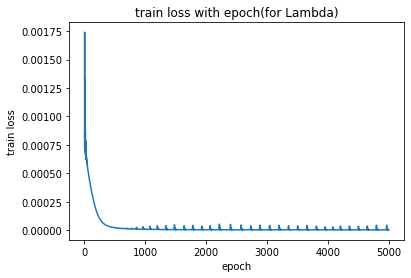

In [69]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch(for Lambda)')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [70]:
prediction_LHS_train=model1(h_tensor,T_tensor) ## prediction on train data
# error_lam_train=mean_squared_error(Lambda_tensor,prediction_LHS_train.detach().numpy())
# error_lam_train
prediction_LHS_train.size()

torch.Size([3000, 1])

In [71]:
prediction_LHS_test=model1(h_tensor_2000,T_tensor_2000) ## prediction on test data from LHS
prediction_LHS_test.shape

torch.Size([2000, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

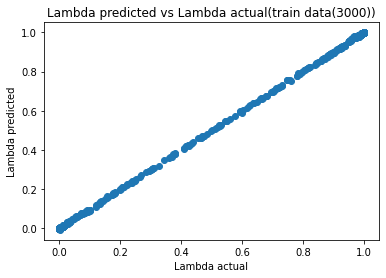

In [72]:
plt.scatter(Lambda_tensor,prediction_LHS_train.detach().numpy())
plt.xlabel("Lambda actual")
plt.ylabel("Lambda predicted")
plt.title('Lambda predicted vs Lambda actual(train data(3000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

<function matplotlib.pyplot.show(close=None, block=None)>

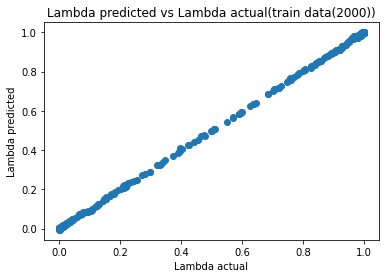

In [73]:
plt.scatter(Lambda_tensor_2000,prediction_LHS_test.detach().numpy())
plt.xlabel("Lambda actual")
plt.ylabel("Lambda predicted")
plt.title('Lambda predicted vs Lambda actual(train data(2000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

In [74]:
prediction_5000_test=model1(h_tensor_5000,T_tensor_5000)# Test Data
prediction_5000_test.shape

torch.Size([5000, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

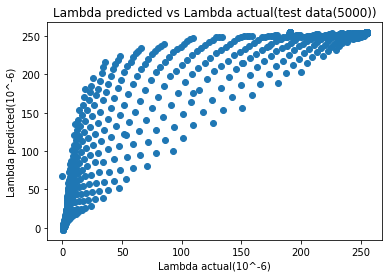

In [75]:
plt.scatter(min_max_scaler_lambda_5000.inverse_transform(Lambda_tensor_5000)*10**6,min_max_scaler_lambda_5000.inverse_transform(prediction_5000_test.detach().numpy())*10**6)  ## why it is matching with the neural network train input of lambda??
plt.xlabel("Lambda actual(10^-6)")
plt.ylabel("Lambda predicted(10^-6)")
plt.title('Lambda predicted vs Lambda actual(test data(5000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

##  plotting lambda precicted vs lambda actual for test data

<function matplotlib.pyplot.show(close=None, block=None)>

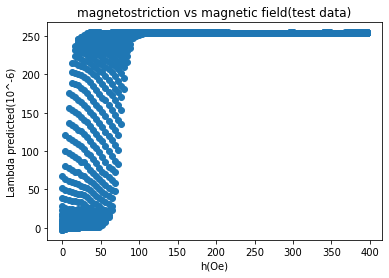

In [76]:
plt.scatter(h_in_notscaled_5000/79.77,min_max_scaler_lambda_5000.inverse_transform(prediction_5000_test.detach().numpy())*10**6)
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted(10^-6)")
plt.title('magnetostriction vs magnetic field(test data)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

<function matplotlib.pyplot.show(close=None, block=None)>

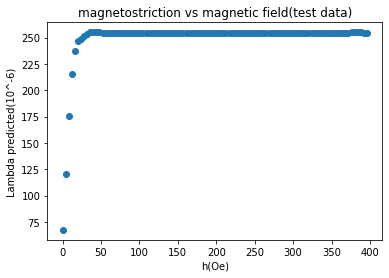

In [77]:
plt.scatter(h_in_notscaled_5000[0:100]/79.77,min_max_scaler_lambda_5000.inverse_transform(prediction_5000_test.detach().numpy())[0:100]*10**6)
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted(10^-6)")
plt.title('magnetostriction vs magnetic field(test data)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

In [84]:
model2=Net()

In [85]:
model2.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.3760, -0.5013],
                      [ 0.1336, -0.0660],
                      [-0.3327,  0.1502],
                      [ 0.2868, -0.4892],
                      [-0.0867,  0.1852],
                      [ 0.6845, -0.5695],
                      [ 0.6242, -0.0684],
                      [ 0.1573, -0.6101],
                      [-0.6220, -0.3620],
                      [-0.0521,  0.1345],
                      [ 0.6324, -0.1170],
                      [ 0.4874, -0.5932],
                      [ 0.3959, -0.6112],
                      [-0.6711,  0.4244],
                      [-0.4616, -0.3908],
                      [-0.4176, -0.1952],
                      [ 0.3453,  0.3540],
                      [-0.5323,  0.0570],
                      [-0.5847, -0.6004],
                      [-0.1806, -0.0607],
                      [ 0.3528,  0.3070],
                      [ 0.1764,  0.5395],
                      [-0.0810, -0.0627],
      

In [60]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 2000
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out= train_iter(model2,h_tensor,Lambda_tensor,T_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.27200547
Epoch: 2
0.2720038
Epoch: 3
0.27200213
Epoch: 4
0.27200052
Epoch: 5
0.2719989
Epoch: 6
0.2719973
Epoch: 7
0.27199572
Epoch: 8
0.27199408
Epoch: 9
0.2719925
Epoch: 10
0.2719909
Epoch: 11
0.2719893
Epoch: 12
0.2719877
Epoch: 13
0.27198613
Epoch: 14
0.27198452
Epoch: 15
0.27198294
Epoch: 16
0.27198133
Epoch: 17
0.27197975
Epoch: 18
0.27197814
Epoch: 19
0.27197656
Epoch: 20
0.27197498
Epoch: 21
0.27197337
Epoch: 22
0.2719718
Epoch: 23
0.2719702
Epoch: 24
0.2719686
Epoch: 25
0.27196705
Epoch: 26
0.27196544
Epoch: 27
0.27196386
Epoch: 28
0.27196229
Epoch: 29
0.2719607
Epoch: 30
0.27195913
Epoch: 31
0.27195755
Epoch: 32
0.27195597
Epoch: 33
0.27195442
Epoch: 34
0.2719528
Epoch: 35
0.27195126
Epoch: 36
0.27194968
Epoch: 37
0.2719481
Epoch: 38
0.27194652
Epoch: 39
0.27194497
Epoch: 40
0.2719434
Epoch: 41
0.27194184
Epoch: 42
0.27194026
Epoch: 43
0.2719387
Epoch: 44
0.27193713
Epoch: 45
0.27193555
Epoch: 46
0.27193397
Epoch: 47
0.27193242
Epoch: 48
0.27193087
Epoch: 49
0.2719

<function matplotlib.pyplot.show(close=None, block=None)>

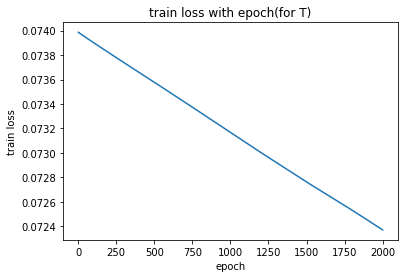

In [61]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch(for T)')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [62]:
prediction_LHS_T_train_3000=model2(h_tensor,Lambda_tensor)
prediction_LHS_T_train_3000.shape

torch.Size([3000, 1])

In [78]:
prediction_LHS_T_train_2000=model2(h_tensor_2000,Lambda_tensor_2000)
prediction_LHS_T_train_2000.shape

torch.Size([2000, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

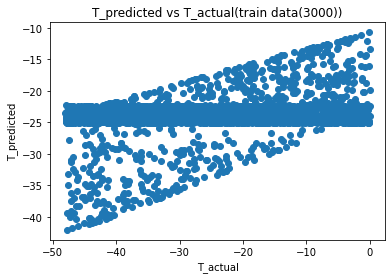

In [80]:
plt.scatter(min_max_scaler_T.inverse_transform(T_tensor)/10**6,min_max_scaler_T.inverse_transform(prediction_LHS_T_train_3000.detach().numpy())/10**6)
plt.xlabel("T_actual")
plt.ylabel("T_predicted")
plt.title('T_predicted vs T_actual(train data(3000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

<function matplotlib.pyplot.show(close=None, block=None)>

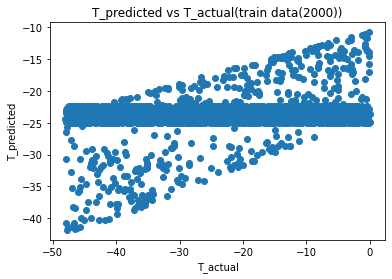

In [83]:
plt.scatter(min_max_scaler_T.inverse_transform(T_tensor_2000)/10**6,min_max_scaler_T.inverse_transform(prediction_LHS_T_train_2000.detach().numpy())/10**6)
plt.xlabel("T_actual")
plt.ylabel("T_predicted")
plt.title('T_predicted vs T_actual(train data(2000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

In [65]:
prediction_5000_T=model2(scale_h_test_in_5000,scale_Lambda_test_in_5000) ## Test Data

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [91]:
scaled_T_output_5000=min_max_scaler_T_5000.inverse_transform(prediction_5000_T.detach().numpy())
error=np.sqrt(mean_squared_error(T_in_notscaled_5000,scaled_T_output_5000))
error

19452238.0

In [88]:
T_in_notscaled_5000

tensor([[        0.],
        [        0.],
        [        0.],
        ...,
        [-47000000.],
        [-47000000.],
        [-47000000.]])

<function matplotlib.pyplot.show(close=None, block=None)>

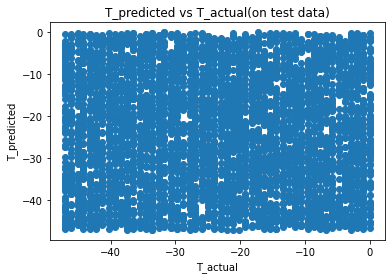

In [87]:
plt.scatter(T_in_notscaled_5000/10**6,scaled_T_output_5000/10**6)
plt.xlabel("T_actual")
plt.ylabel("T_predicted")
plt.title('T_predicted vs T_actual(on test data)')
# plt.yticks(np.linspace(150,200,10))
plt.show
## plotting T precicted vs T actual for test set